In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from collections import Counter
from pprint import pprint

### Load data

In [2]:
df = pd.read_csv('Data/4-clean data.csv')
df.fillna("", inplace=True)
print(df.shape)
df.head()

(11184, 7)


,job_title,location,career_level,experience,job_type,job_description,required_skills
0,data analyst,johor bahru,non-executive,not specified,full-time,zempot malaysia sdn bhd is a newly branched co...,"['data analytics', 'knowledge in online table ..."
1,director- data analytics,petaling jaya,senior manager,12,full-time,job overviewwe are looking for a highly motiva...,"['data science', 'business intelligence', 'mac..."
2,solutions architect - data lake specialist (ba...,kuala lumpur,senior executive,8,full-time,we are looking for a solutions architect who s...,"['data lake architecture', 'data modelling', '..."
3,automotive analyst – vehicle valuation,kuala lumpur,senior executive,3,full-time,descriptionthe automotive analyst will be acco...,"['data analysis', 'market research', 'database..."
4,it business analyst,kuala lumpur,senior executive,4,full-time,position objective:-responsible to be the it b...,


In [3]:
df[['required_skills']].head(10)

,required_skills
0,"['data analytics', 'knowledge in online table ..."
1,"['data science', 'business intelligence', 'mac..."
2,"['data lake architecture', 'data modelling', '..."
3,"['data analysis', 'market research', 'database..."
4,
5,"['programming languages like mysql', 'database..."
6,"['machine learning', 'deep learning', 'data qu..."
7,"['BI ETL', 'DWH projects', 'Informatica', 'Azu..."
8,
9,


### Tokenize

In [4]:
def tokenize(X):
    #convert to lowercase
    X = X.str.lower()
    
    #Remove punctuation
    X =  X.str.replace('\[','', regex=True) 
    X =  X.str.replace(']','', regex=True) 
    X =  X.str.replace('\(','', regex=True) 
    X =  X.str.replace('\)','', regex=True) 
    X =  X.str.replace("'",'', regex=True) 
    
    #tokenize
    group = []
    for i in range(len(X)):     
        sent = X[i].split(',')
        sent = [element.strip() for element in sent if len(element.split()) <= 5] # phrases that consist of a maximum of 5 words 
        group = group + sent
    group =  [x for x in group if x != ""]
   
    return group

In [5]:
skillset = tokenize(df['required_skills'])
print('number of total skills:',  len(skillset), '\n')
count = pd.Series(skillset).value_counts()
print("Element Count: ")
print(count)

number of total skills: 24234 

Element Count: 
data analysis                                     483
data entry                                        266
project management                                184
financial analysis                                175
inventory management                              152
                                                 ... 
drill                                               1
inventory forecasting                               1
parts management                                    1
meticulousnesssupply chain management software      1
aml/kyc certificationsms office products            1
Name: count, Length: 11942, dtype: int64


#### can't drop duplicates, need to find most common skillset in result

### Vectorize

###  a) tfidf: (phrase)

In [6]:
vectorizer = TfidfVectorizer(stop_words="english")
X_tfidf = vectorizer.fit_transform(skillset)
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}", '\n')

print('Document index, Specific word-vector index, TFIDF score: \n', X_tfidf[0], '\n')
X1 = X_tfidf.toarray()
print(X1[0])

n_samples: 24234, n_features: 6283 

Document index, Specific word-vector index, TFIDF score: 
   (0, 344)	0.8627008873865464
  (0, 1425)	0.5057145231278862 

[0. 0. 0. ... 0. 0. 0.]


- no implememtation of data normalization since data already in range(0,1), and standard scaler will reduce diversity of the data which is more difficult to identify different skillset groups.
- by test, the evaluation reaches best when there is fewer groups, which is not supporting our initial objectives that identify different groups among skillsets

### Reduce feature dimension by PCA

In [8]:
km = KMeans(n_clusters=3, n_init=10)  
numfeatures = [50, 25, 10, 5, 4, 3, 2] #reduce dimension of features
sc = []
dbi = []
for i in numfeatures:
    pca = PCA(n_components = i)
    X2 = pca.fit_transform(X1) 
    km.fit(X2)
    sc.append(metrics.silhouette_score(X2, km.labels_))
    dbi.append( metrics.davies_bouldin_score(X2, km.labels_))
print(sc,'\n',dbi) 

[0.37844817222201965, 0.4160851086747307, 0.5693203946349438, 0.6808486868797811, 0.7185284373151847, 0.784673891895755, 0.8305847365803669] 
 [1.2753041575131145, 1.3107877854846506, 0.8449854981282581, 0.8573502529682572, 0.5861604167504318, 0.763748069720566, 0.4735890117209623]


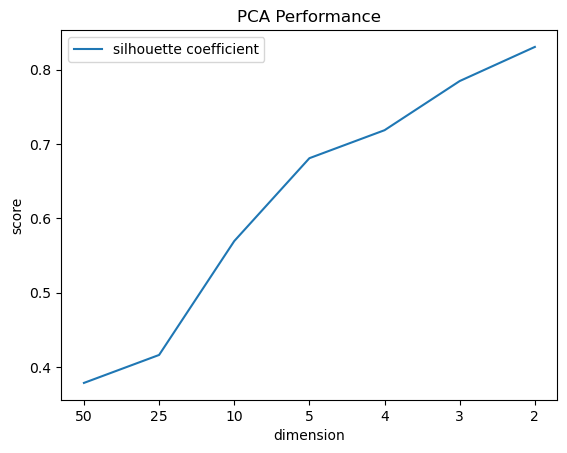

In [9]:
x = [str(ele) for ele in numfeatures]
plt.plot(x, sc)
plt.legend(['silhouette coefficient'])
plt.title('PCA Performance')
plt.xlabel('dimension')
plt.ylabel('score')
plt.show()

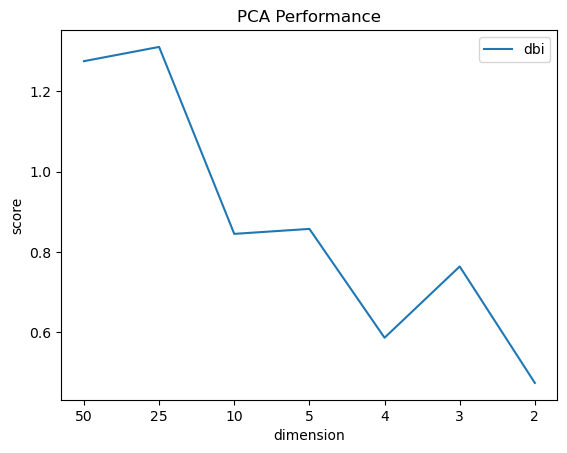

In [10]:
plt.plot(x, dbi)
plt.legend(['dbi'])
plt.title('PCA Performance')
plt.xlabel('dimension')
plt.ylabel('score')
plt.show()

 - set number of features as 4

In [7]:
pca = PCA(n_components = 4)
final_X = pca.fit_transform(X1)

### Elbow Method 

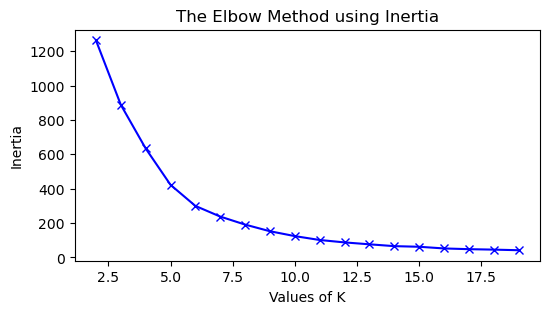

In [9]:
def elbow(data):
    inertia = [] 
    K = range(2, 20)
    for i in K: 
        kmeans = KMeans(n_clusters = i, n_init= 10, max_iter = 10)
        kmeans.fit(data) 
        inertia.append(kmeans.inertia_)
    plt.figure(figsize=(6,3),dpi=100)
    plt.plot(K, inertia, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Inertia')
    plt.title('The Elbow Method using Inertia')
    plt.show()

elbow(final_X)

- set k=6 based on the elbow result 

### K-means

#### initial centroids 

In [20]:
a = [10, 15, 20]
for i in a:
    km = KMeans(n_clusters=6, n_init=i, max_iter = 50) 
    km.fit(final_X)    
    print('n_init: ', i)
    print("Silhouette Coefficient: %0.2f"
          % metrics.silhouette_score(final_X, km.labels_))
    print("Davies Bouldin Score: %0.2f"
          % metrics.davies_bouldin_score(final_X, km.labels_))

n_init:  10
Silhouette Coefficient: 0.81
Davies Bouldin Score: 0.60
n_init:  15
Silhouette Coefficient: 0.81
Davies Bouldin Score: 0.60
n_init:  20
Silhouette Coefficient: 0.81
Davies Bouldin Score: 0.60


#### iteration:

In [25]:
a = [300, 100, 50, 10, 5]
for i in a:
    km = KMeans(n_clusters=6, n_init=10, max_iter = i) 
    km.fit(final_X)    
    print('max_iter: ', i)
    print("Silhouette Coefficient: %0.2f"
          % metrics.silhouette_score(final_X, km.labels_))
    print("Davies Bouldin Score: %0.2f"
          % metrics.davies_bouldin_score(final_X, km.labels_))

max_iter:  300
Silhouette Coefficient: 0.81
Davies Bouldin Score: 0.60
max_iter:  100
Silhouette Coefficient: 0.81
Davies Bouldin Score: 0.60
max_iter:  50
Silhouette Coefficient: 0.81
Davies Bouldin Score: 0.60
max_iter:  10
Silhouette Coefficient: 0.81
Davies Bouldin Score: 0.60
max_iter:  5
Silhouette Coefficient: 0.81
Davies Bouldin Score: 0.60


In [ ]:
print("Silhouette Coefficient: %0.2f"
          % metrics.silhouette_score(final_X, km.labels_))
print("Davies Bouldin Score: %0.2f"
          % metrics.davies_bouldin_score(final_X, km.labels_))

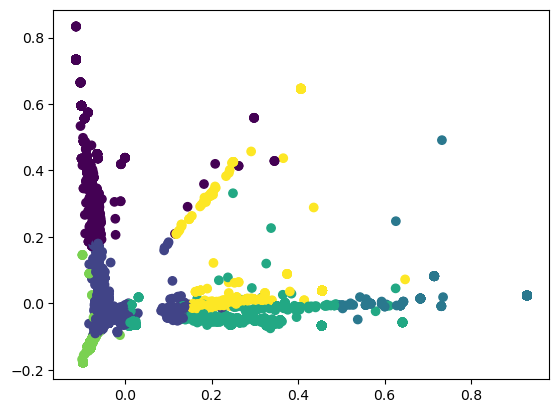

In [11]:
#plot the clustering 
plt.scatter(final_X[:,0], final_X[:,1], c=km.labels_)
plt.show()

In [12]:
result = pd.DataFrame({'skillset':skillset, 'kmeans': km.labels_})
result.head()

,skillset,kmeans
0,data analytics,2
1,knowledge in online table game,1
2,ms excel proficiencyms excel,4
3,data science,2
4,business intelligence,1


In [13]:
print(result.groupby('kmeans')['skillset'].count())
skill_list = pd.DataFrame(result.groupby('kmeans')['skillset'].apply(list))
skill_list

kmeans
0      990
1    18833
2     1077
3      607
4      707
5     2020
Name: skillset, dtype: int64


,skillset
kmeans,
0,"[time-series analysis, localizationdata analys..."
1,"[knowledge in online table game, business inte..."
2,"[data analytics, data science, data robot, dat..."
3,"[data analysis, data analysis, data analysis, ..."
4,"[ms excel proficiencyms excel, microsoft azure..."
5,"[database management, sql server management st..."


In [1]:
for i in skill_list.index:
    occurence = Counter(skill_list.iloc[i][0])
    most_common = occurence.most_common(30)
    pprint(most_common)
    most_common = list(zip(*most_common))[0]

NameError: name 'skill_list' is not defined

In [15]:
#result.to_csv('skillset groups.csv', index=False)

### DBSCAN

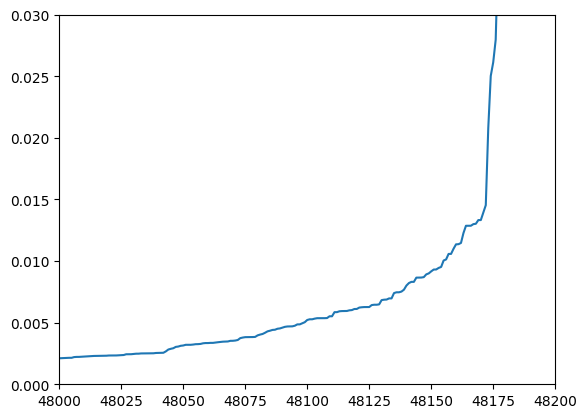

In [31]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
def nn(data):
    neigh = NearestNeighbors(n_neighbors=10)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
    plt.xlim(48000, 48200)
    plt.ylim(0,0.03)
    #plt.xscale('log', base = 2)
    plt.show()

nn(pca_tfidf)

45.212 s
Silhouette Coefficient(close to 1 is better): 0.626
Davies Bouldin Score(lower is better): 1.039
number of clusters:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, -1}


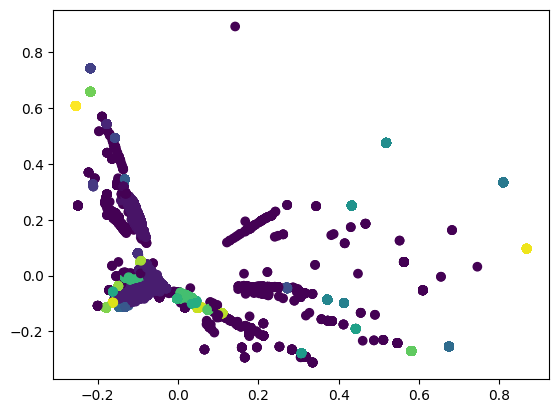

In [21]:
# Epsilon: radius of local neighborhood. n_clu: minimum density threshold.
epsilon, n_clu = 0.01, 50

# build model
start = time.time()
dbscan = DBSCAN(eps = epsilon, min_samples = n_clu)
dbscan.fit(pca_tfidf)
end = time.time()
print(round(end-start, 3), 's')

print("Silhouette Coefficient(close to 1 is better): %0.3f"
      % metrics.silhouette_score(pca_tfidf, dbscan.labels_))
print("Davies Bouldin Score(lower is better): %0.3f"
      % metrics.davies_bouldin_score(pca_tfidf, dbscan.labels_))
print('number of clusters: ', set(dbscan.labels_))

#plot the clustering 
plt.scatter(pca_tfidf[:,0], pca_tfidf[:,1], c=dbscan.labels_)
plt.show()

### Hierarchical

Silhouette Coefficient(close to 1 is better): 0.676
Davies Bouldin Score(lower is better): 0.442


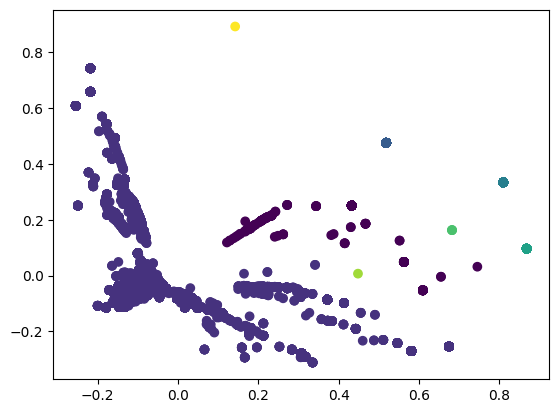

In [36]:
from sklearn.cluster import AgglomerativeClustering
agglomerative = AgglomerativeClustering(n_clusters= 8, linkage='single')
agglomerative.fit_predict(pca_tfidf)

print("Silhouette Coefficient(close to 1 is better): %0.3f"
      % metrics.silhouette_score(pca_tfidf, agglomerative.labels_))
print("Davies Bouldin Score(lower is better): %0.3f"
      % metrics.davies_bouldin_score(pca_tfidf, agglomerative.labels_))

#plot the clustering 
plt.scatter(pca_tfidf[:,0], pca_tfidf[:,1], c=agglomerative.labels_)
plt.show()